In [1]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

In [ ]:
pip install tabulate

# Assignment - Antoine CLOUTE

## Initialize the environment

In [3]:
# imports

import os, sys
import gymnasium as gym

import text_flappy_bird_gym

import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict

matplotlib.style.use('classic')

## Agent n°1: Q-Learning

### Class definition

In [27]:
class QLearningAgent():
    def __init__(self, num_actions,epsilon,eps_decay,step_size,step_size_decay,discount,seed):
        """Setup for the agent called when the experiment first starts.
        
        Args:
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            eps_decay (float): The decay rate of the epsilon parameter,
            step_size (float): The step-size,
            step_size_decay (float): The decay rate of the step-size parameter,
            discount (float): The discount factor
        
        """
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.step_size = step_size
        self.step_size_decay = step_size_decay
        self.discount = discount
        self.rand_generator = np.random.RandomState(seed)
        
        # Create a dictionary for action-value estimates
        self.q = defaultdict(lambda: 0)

    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        self.prev_state = state
        self.prev_action = action

        return action


    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the environment's step based on where the agent ended up after the last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Set an array that will store the current q_values
        current_q =  [self.q[(state, 0)], self.q[(state, 1)]]

        # Choose action using epsilon greedy.
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection

        # Perform an update
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward + self.discount * np.max(current_q) - self.q[(self.prev_state, self.prev_action)])    


        # Decay for the step-size
        if self.step_size > 0.1:
                self.step_size = max(self.step_size * self.step_size_decay, 0.1) 

        # Decay for the epsilon
        if self.epsilon > 0.0001:
                self.epsilon = max(self.epsilon * self.eps_decay, 0.0001) 
        
        self.prev_state = state
        self.prev_action = action
        return action
    

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
            state(int):the state from the environment's step based on where the agent ended up after the
                last step.
        """
        # Perform the last update in the episode
        self.q[(self.prev_state, self.prev_action)] += self.step_size * (reward - self.q[(self.prev_state, self.prev_action)])     
        

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)
    
    def train(self, env, num_episodes):
        """Train the agent (include both exploration and exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to train the agent on
            
        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list) : list of the scores obtained for each episode
        """
        rewards = []
        scores = []
        for episode in tqdm(range(num_episodes)):
            episode_rewards = 0
            state, _ = env.reset()
            if episode ==0:
                action = self.agent_start(state)
            else:
                while True:
                    next_state, reward, done, _, info = env.step(action)
                    next_action = self.agent_step(reward, next_state)
                    episode_rewards += reward
                    if done:
                        self.agent_end(reward)
                        break
                    state = next_state
                    action = next_action
                rewards.append(episode_rewards)
                scores.append(info['score'])
        return rewards, scores


    def test(self, env, n_episodes):
        """Test the agent (include only exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to test the agent on
            
        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list): list of the scores obtained for each episode
        """
        rewards = []
        scores = []
        for episode in tqdm(range(n_episodes)):
            episode_rewards = 0
            state, _ = env.reset()
            while True:
                q_values = [self.q[(state, 0)], self.q[(state, 1)]]
                action = self.argmax(q_values)
                next_state, reward, done, _, info = env.step(action)
                episode_rewards += reward
                if done:
                    break
                state = next_state
                if info['score'] >1e5: #Stopping condition to avoid it to be stuck if it never dies
                    break
            rewards.append(episode_rewards)
            scores.append(info['score'])
        return rewards, scores


### Baseline

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 742.72it/s]


Average reward over 10000 train episodes: 46.977597759775975
Median reward over 10000 train episodes: 23.0
Average scores over 10000 train episodes: 3.5456545654565454
Median scores over 10000 train episodes: 1.0


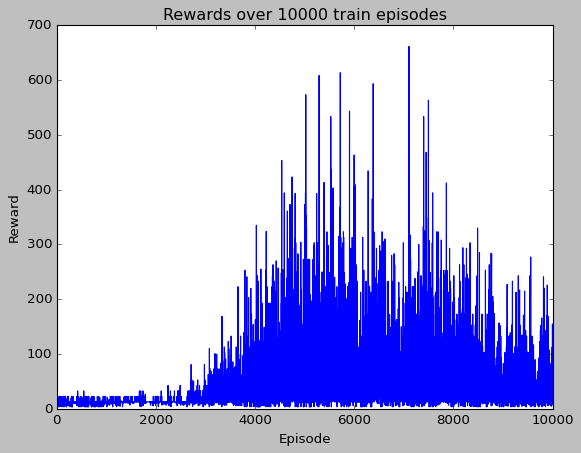

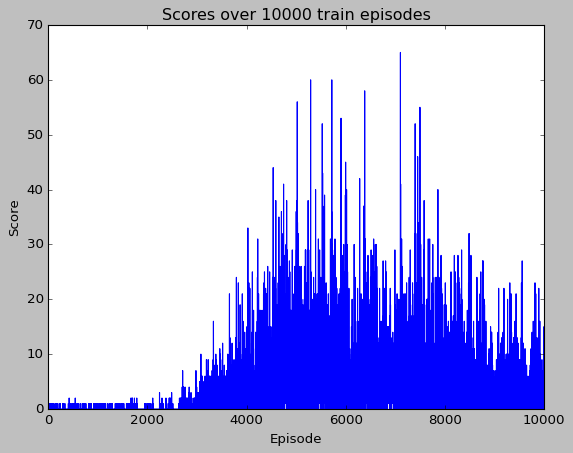

In [5]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)


n_episodes = 10000
# create the Q_learning agent
Q_agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.7,step_size_decay=1,discount=1,seed=0)

# train the Q_learning agent
train_rewards, train_scores = Q_agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Average scores over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median scores over {n_episodes} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()


### Hyperparameter tuning

#### Step-Size

In [6]:
labels = ["alpha = 0.1","alpha = 0.2","alpha = 0.3","alpha = 0.4", "alpha = 0.5","alpha = 0.6", "alpha = 0.7","alpha = 0.8", "alpha = 0.9"]
step_sizes = [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for step_size in step_sizes:
    n_episodes = 10000
    # create the Q Learning agent
    agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=step_size,step_size_decay=1,discount=1,seed=0)
    # train the Q Learning agent
    train_rewards, train_scores = agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 837.13it/s]


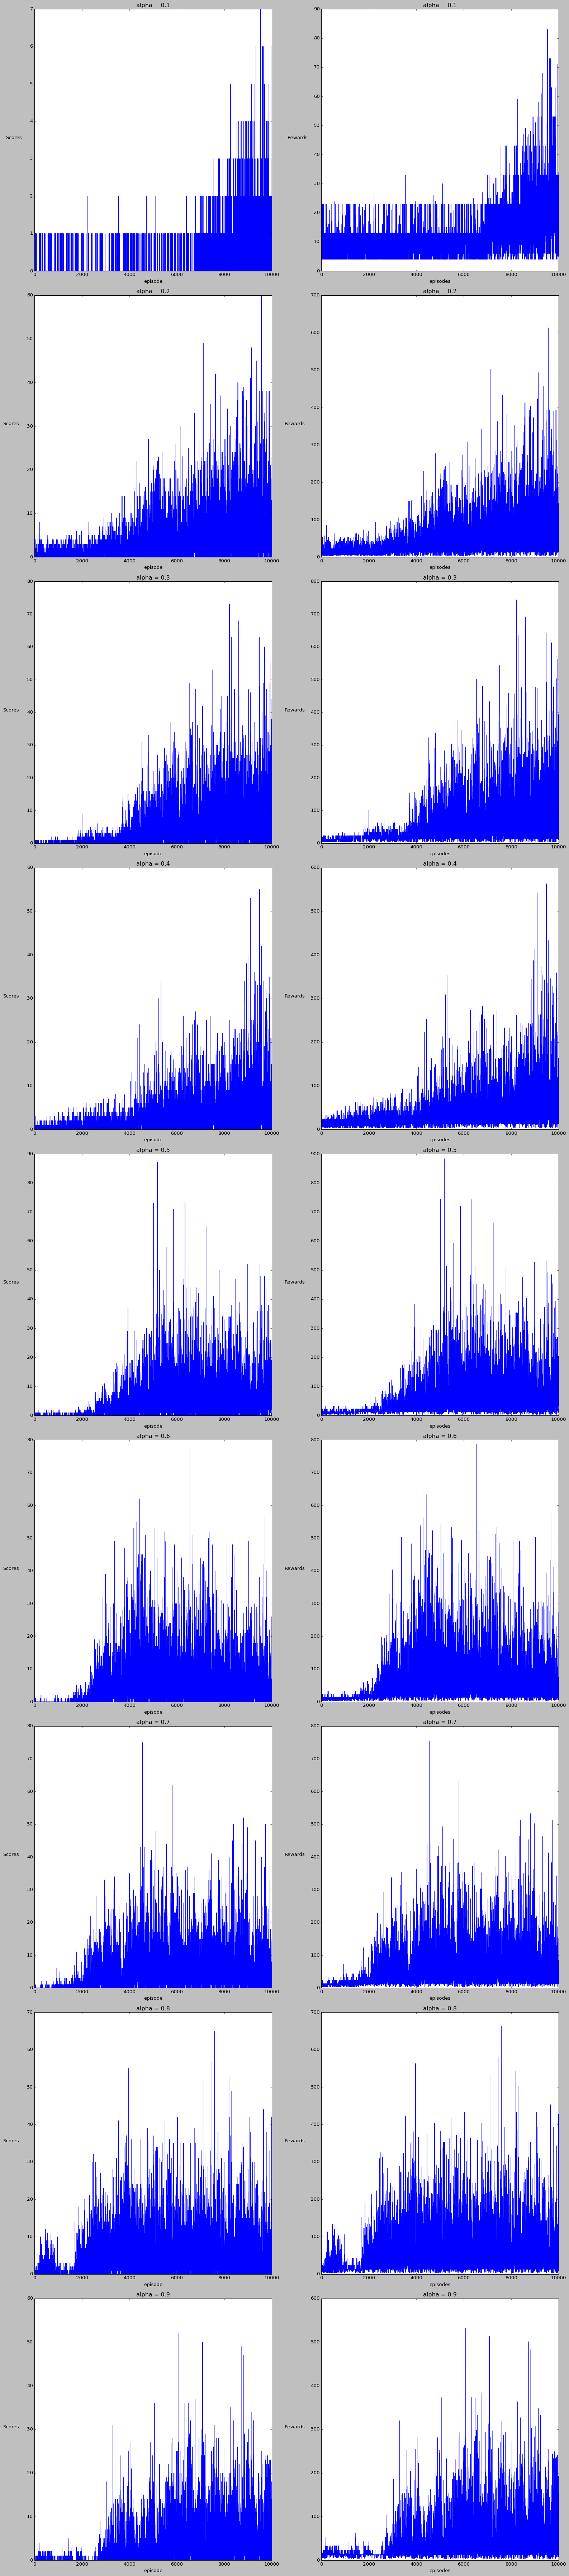

In [7]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("episode")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()


In [8]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒═════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label       │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞═════════════╪═════════════════╪═══════════════════╪════════════════╡
│ alpha = 0.1 │         12.0351 │                13 │             83 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.2 │         43.7682 │                25 │            613 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.3 │         50.2561 │                23 │            744 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.4 │         37.3612 │                23 │            563 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.5 │         54.3239 │                28 │            883 │
├─────────────┼─────────────────┼───────────────────┼────────────────┤
│ alpha = 0.6 │         60.2242 │                33 │            788 │
├─────

#### Epsilon

In [9]:
labels = ["epsilon = 0.05", "epsilon = 0.1","epsilon = 0.15", "epsilon = 0.2","epsilon = 0.25", "epsilon = 0.3"]
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for epsilon in epsilons:
    n_episodes = 10000
    # create the Q Learning agent
    agent = QLearningAgent(num_actions=2,epsilon=epsilon,eps_decay=1,step_size=0.5,step_size_decay=1,discount=1,seed=0)
    # train the Q Learning agent
    train_rewards, train_scores = agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)



100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1229.41it/s]


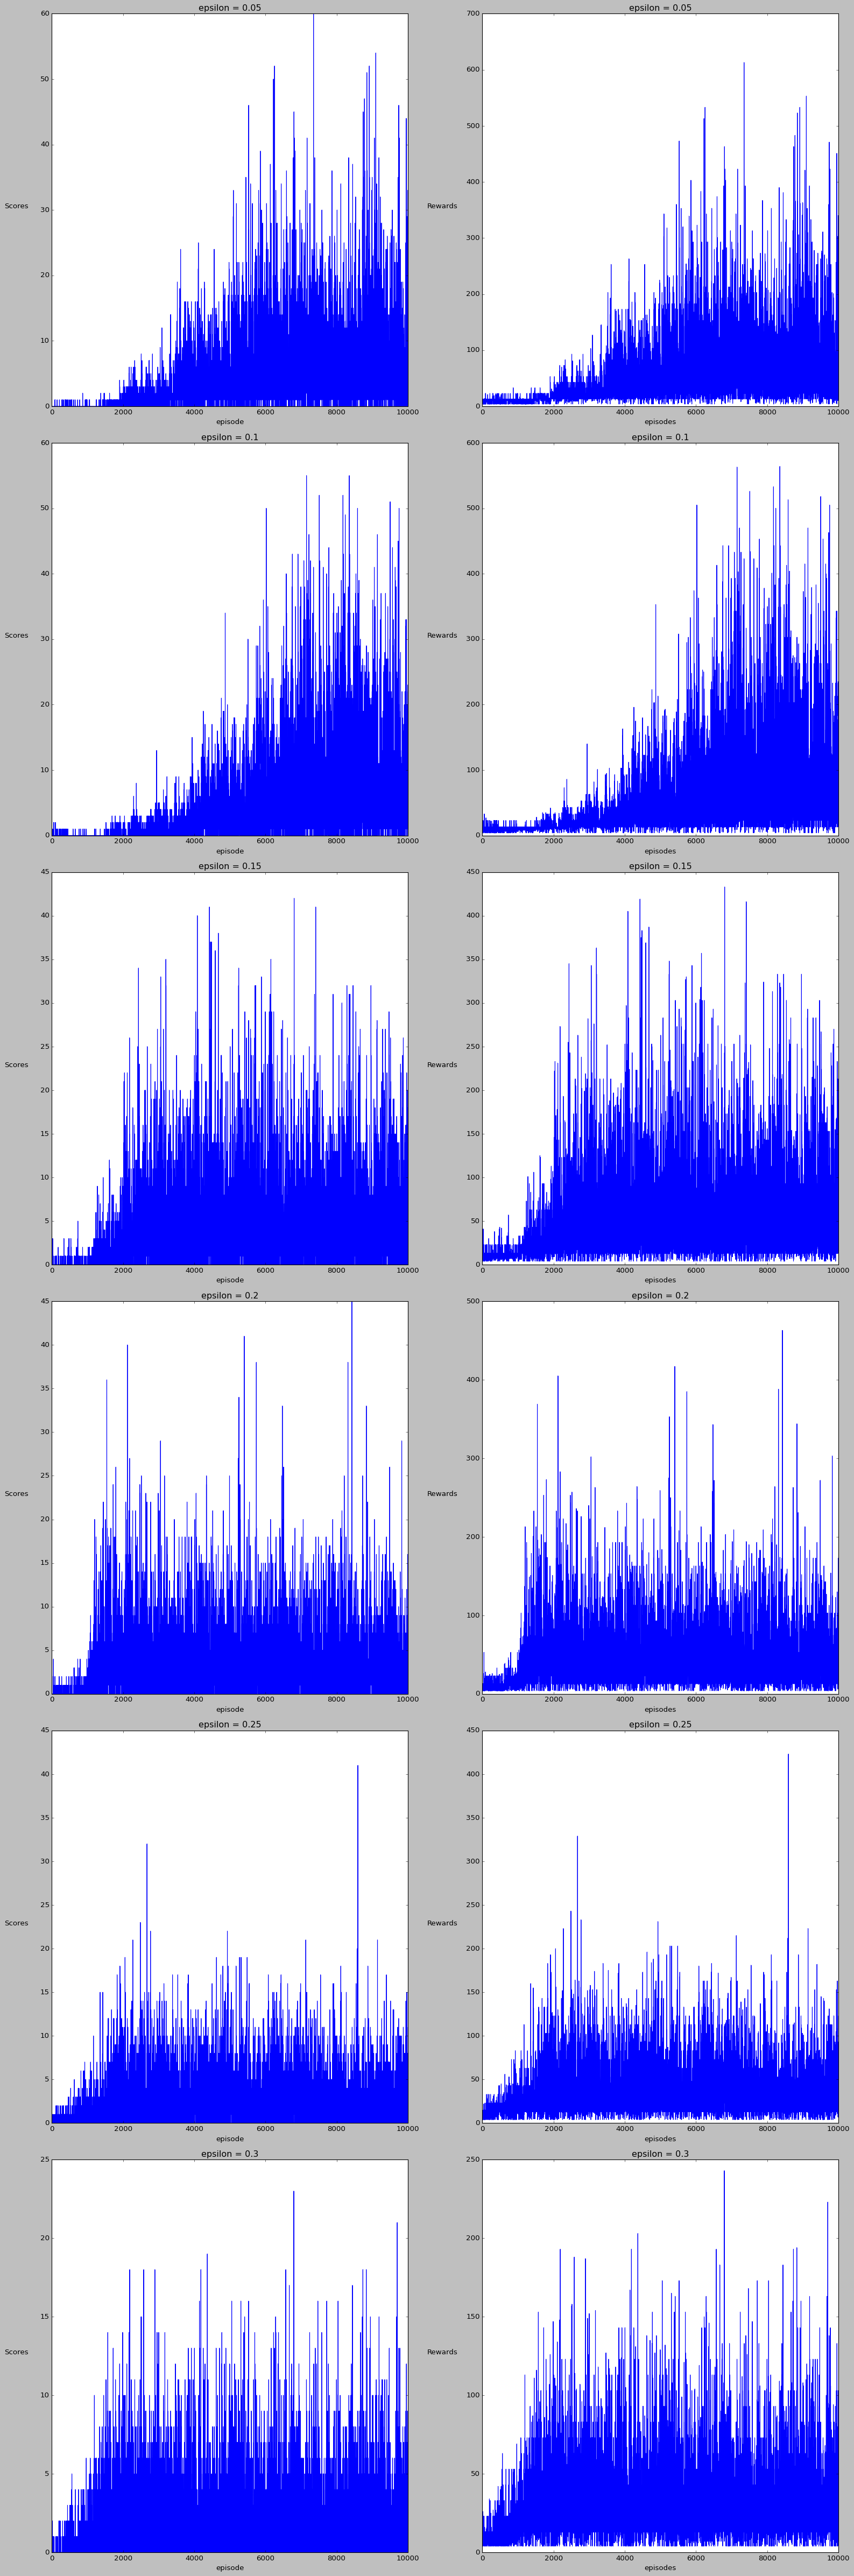

In [10]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("episode")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [11]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒════════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label          │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞════════════════╪═════════════════╪═══════════════════╪════════════════╡
│ epsilon = 0.05 │         50.0136 │                30 │            613 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.1  │         51.359  │                24 │            564 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.15 │         49.6849 │                33 │            433 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.2  │         42.0997 │                32 │            463 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.25 │         34.5077 │                23 │            423 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.3  │         30.0145 │  

#### Discount

In [12]:
labels = ["discount = 1.0", "discount = 0.95","discount = 0.9", "discount = 0.85","discount = 0.8", "discount = 0.75", "discount = 0.7"]
discounts = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for discount in discounts:
    n_episodes = 10000
    # create the Q Learning agent
    agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.5,step_size_decay=1,discount=discount,seed=0)
    # train the Q Learning agent
    train_rewards, train_scores = agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 787.46it/s]


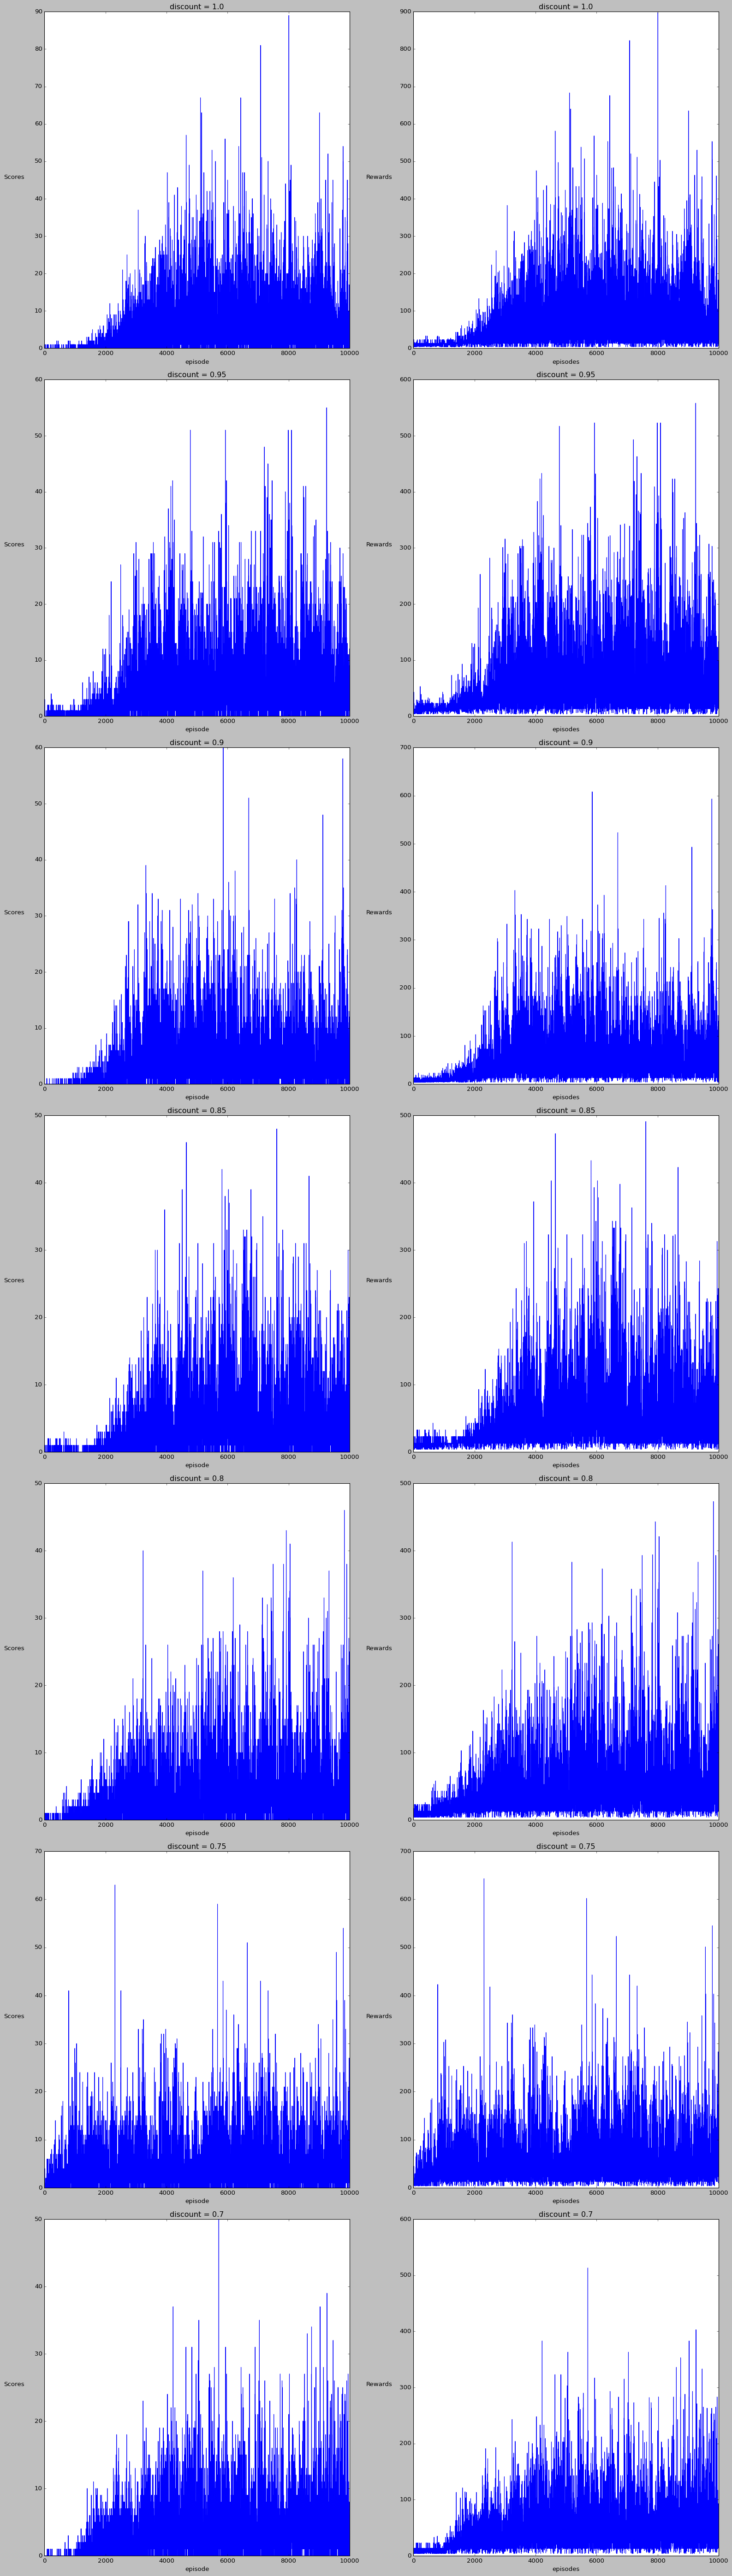

In [13]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("episode")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [14]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒═════════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label           │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞═════════════════╪═════════════════╪═══════════════════╪════════════════╡
│ discount = 1.0  │         61.9084 │                33 │            898 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ discount = 0.95 │         54.2154 │                33 │            558 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ discount = 0.9  │         48.8197 │                33 │            608 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ discount = 0.85 │         46.7274 │                30 │            491 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ discount = 0.8  │         45.2648 │                33 │            473 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ discount = 0.75 │      

#### Step-size decay

In [15]:
labels = ["decay = 1.0", "decay = 0.99999","decay = 0.9999", "decay = 0.999","decay = 0.99", "decay =0.95", "decay = 0.9", "decay = 0.85"]
ss_decays = [1.0, 0.99999, 0.9999, 0.999, 0.99, 0.95, 0.9, 0.85]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for ss_decay in ss_decays:
    n_episodes = 10000
    # create the Q Learning agent
    agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=1,step_size=0.5,step_size_decay=ss_decay,discount=1,seed=0)
    # train the Q Learning agent
    train_rewards, train_scores = agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3086.42it/s]


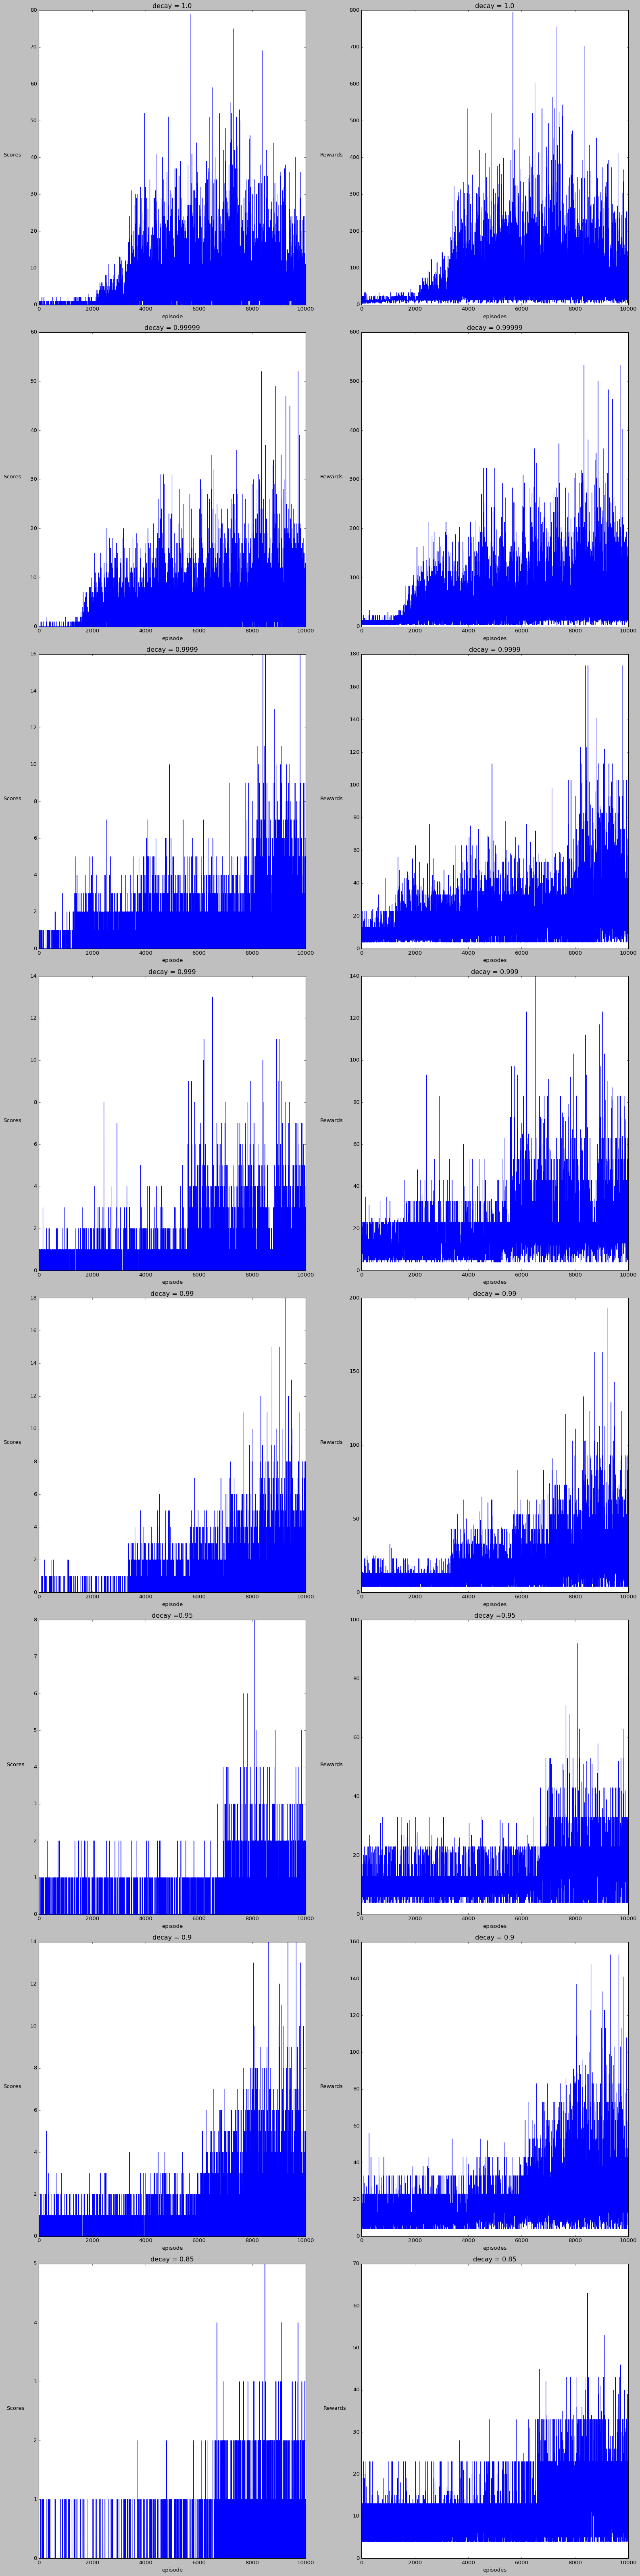

In [16]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("episode")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [17]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒═════════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label           │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞═════════════════╪═════════════════╪═══════════════════╪════════════════╡
│ decay = 1.0     │         59.8894 │                33 │            795 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay = 0.99999 │         45.8276 │                33 │            533 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay = 0.9999  │         18.5057 │                15 │            173 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay = 0.999   │         17.1722 │                13 │            140 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay = 0.99    │         16.1757 │                13 │            193 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay =0.95     │      

#### Epsilon decay

In [18]:
labels = ["decay = 1.0", "decay = 0.99999","decay = 0.9999"]
eps_decays = [1.0, 0.99999,  0.9999 ]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for eps_decay in eps_decays:
    n_episodes = 5000
    # create the Q Learning agent
    agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=eps_decay,step_size=0.5,step_size_decay=1,discount=1,seed=0)
    # train the Q Learning agent
    train_rewards, train_scores = agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1041.02it/s]


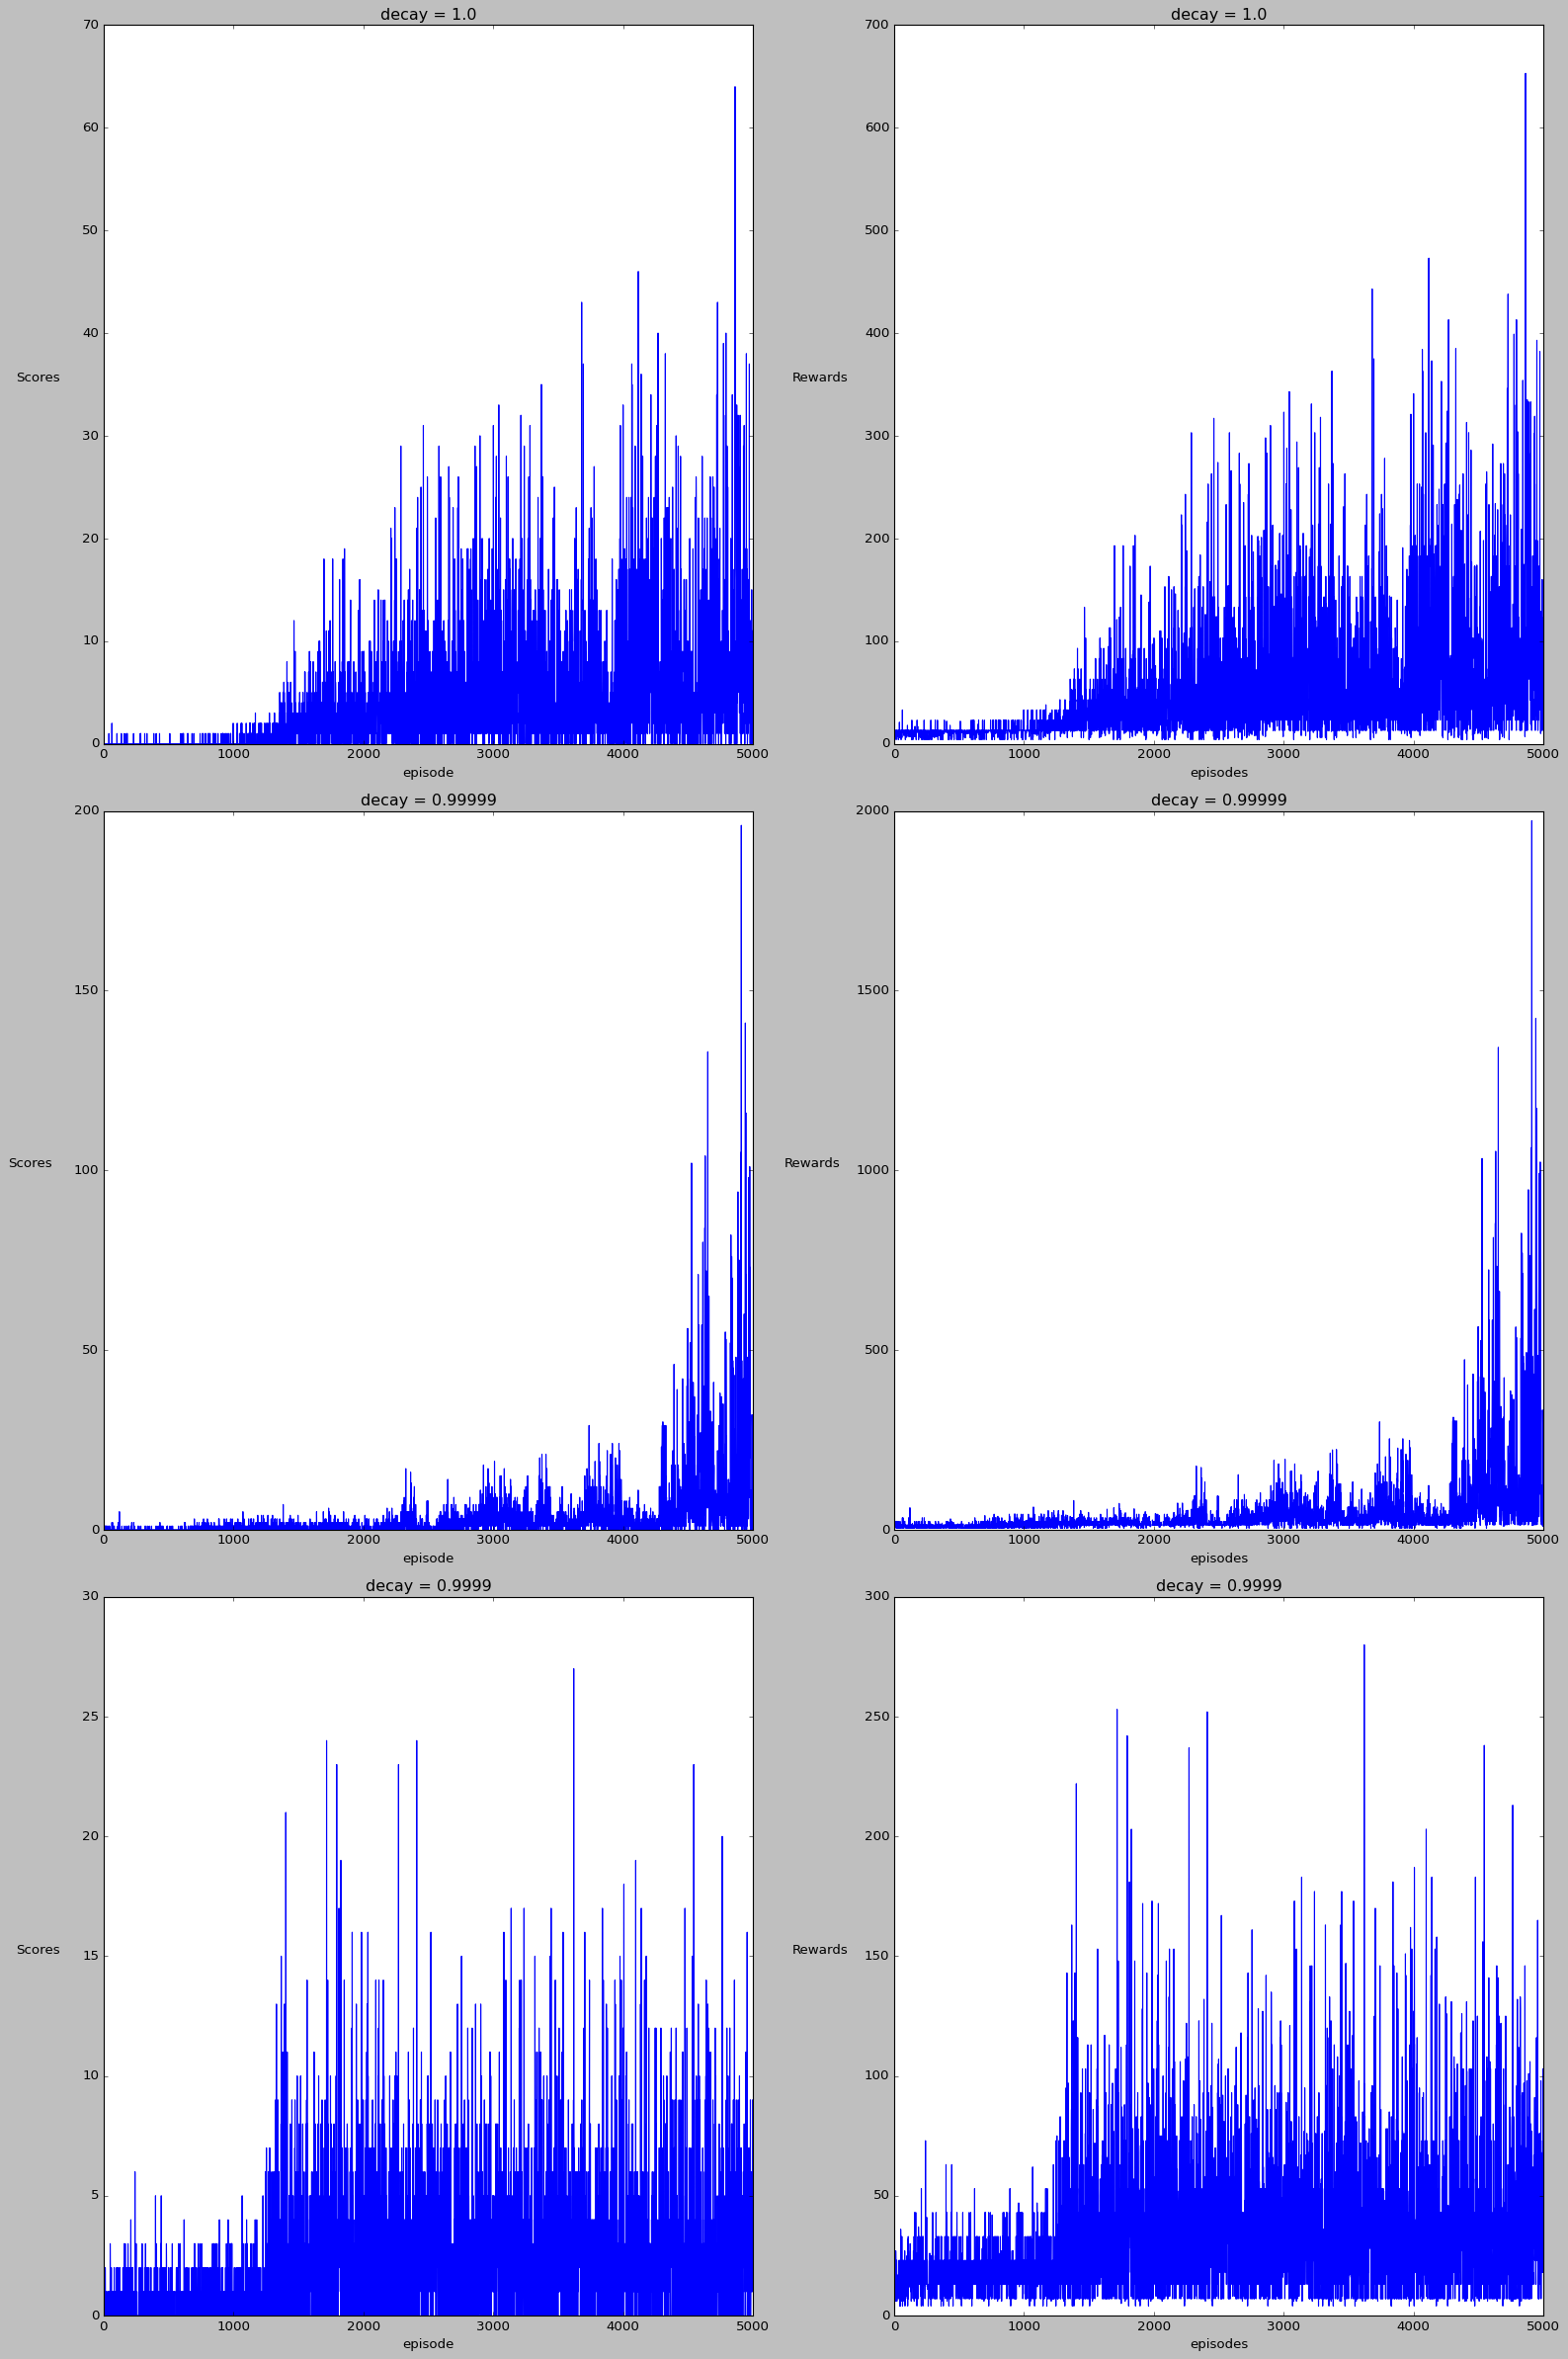

In [19]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("episode")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [20]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒═════════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label           │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞═════════════════╪═════════════════╪═══════════════════╪════════════════╡
│ decay = 1.0     │         49.6447 │                25 │            653 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay = 0.99999 │         44.5023 │                23 │           1973 │
├─────────────────┼─────────────────┼───────────────────┼────────────────┤
│ decay = 0.9999  │         32.976  │                23 │            280 │
╘═════════════════╧═════════════════╧═══════════════════╧════════════════╛
╒═════════════════╤════════════════╤══════════════════╤═══════════════╕
│ Label           │   Mean(Scores) │   Median(Scores) │   Max(Scores) │
╞═════════════════╪════════════════╪══════════════════╪═══════════════╡
│ decay = 1.0     │        3.80776 │                2 │            64 │
├─────────────────┼────────────────┼─

### Optimal Model

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:46<00:00, 37.98it/s]


Average reward over 20000 train episodes: 891.9042952147607
Median reward over 20000 train episodes: 453.0
Average scores over 20000 train episodes: 88.04940247012351
Median scores over 20000 train episodes: 44.0


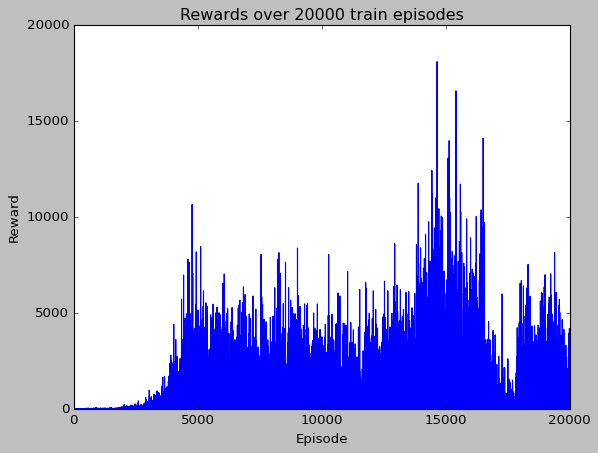

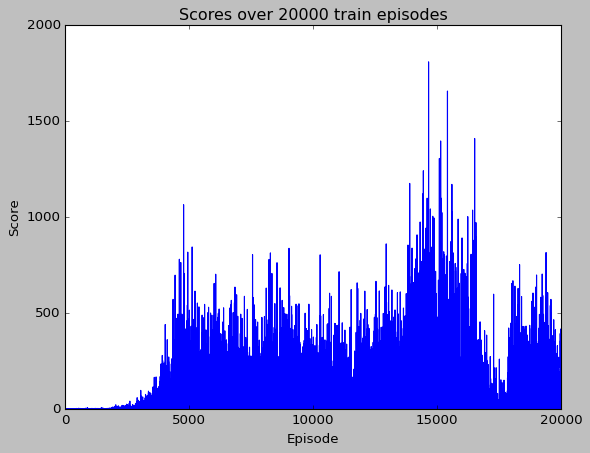

In [78]:
agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=0.99999,step_size=0.5,step_size_decay=1,discount=1,seed=0)

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
n_episodes=20000
# train the QLearning agent
train_rewards, train_scores = agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Average scores over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median scores over {n_episodes} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.17it/s]


Average reward over 100 test episodes: 1280.85
Median reward over 100 test episodes: 811.0
Average scores over 100 test episodes: 127.47
Median scores over 100 test episodes: 80.5


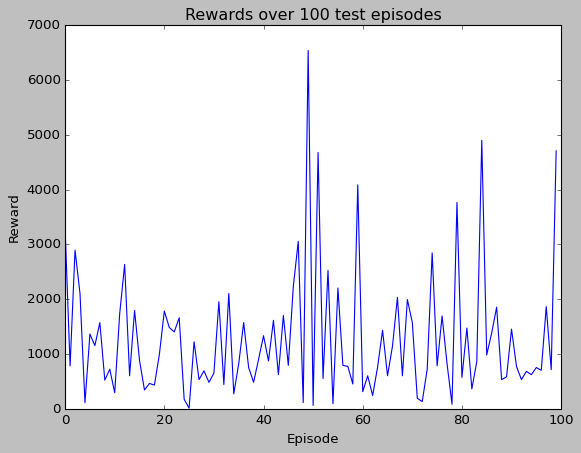

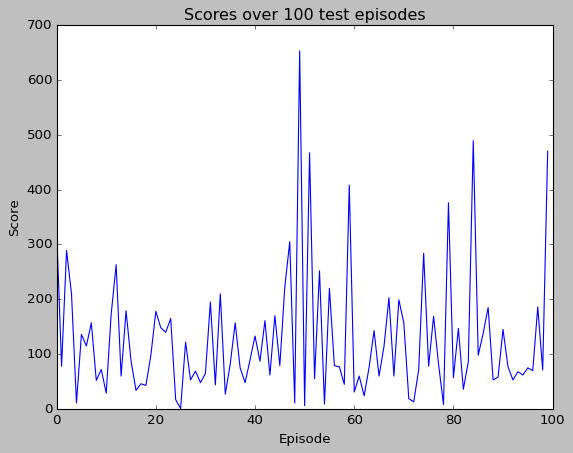

In [22]:
# test the trained agent for 100 episodes
n_episodes=100
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
test_rewards,test_scores = agent.test(env,n_episodes=n_episodes)
print(f"Average reward over {n_episodes} test episodes:", np.mean(test_rewards))
print(f"Median reward over {n_episodes} test episodes:", np.median(test_rewards))
print(f"Average scores over {n_episodes} test episodes:", np.mean(test_scores))
print(f"Median scores over {n_episodes} test episodes:", np.median(test_scores))


# plot the rewards
plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} test episodes")
plt.show()

# plot the scores
plt.plot(test_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} test episodes")
plt.show()

### Perfomance Graphs

#### Convergence time

In [28]:
# Set up a list of episodes to test
num_episodes_list = [1000, 2000, 3000, 4000]

# Set up a list to store the average scores/rewards
avg_scores = []
avg_rewards= []

# Loop through each episode count
for num_episodes in num_episodes_list:
    
    # Initialize the environment
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

    # Train the QLearning agent on the specified number of episodes
    agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=0.99999,step_size=0.5,step_size_decay=1,discount=1,seed=0)
    agent.train(env,num_episodes)

    # Test the agent 
    test_rewards,test_scores = agent.test(env,10)

    # Calculate the average score for the test
    avg_score = np.mean(test_scores)
    avg_reward = np.mean(test_rewards)
    
    # Add the average score/reward to the list
    avg_scores.append(avg_score)
    avg_rewards.append(avg_reward)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.65it/s]


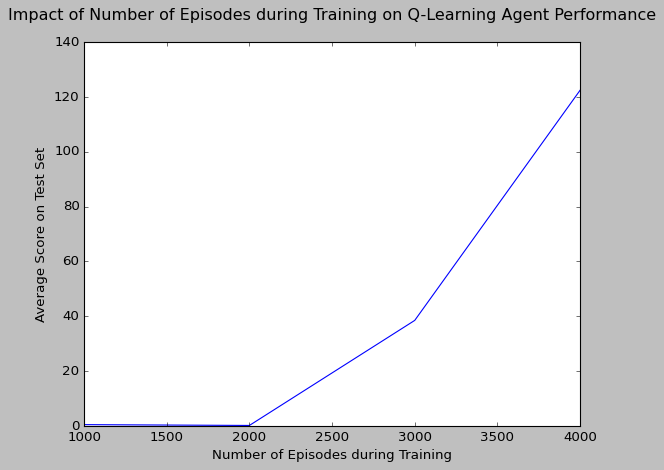

In [29]:
# Plot the parameter sweep graph
plt.plot(num_episodes_list, avg_scores)
plt.xlabel("Number of Episodes during Training")
plt.ylabel("Average Score on Test Set")
plt.title("Impact of Number of Episodes during Training on Q-Learning Agent Performance", pad=20)
plt.show()

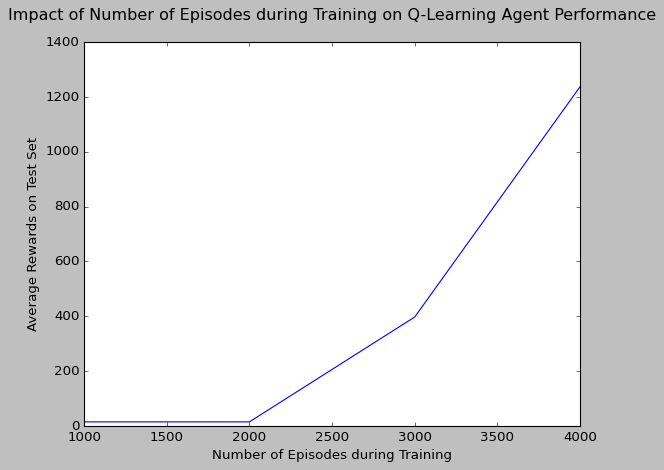

In [30]:
# Plot the parameter sweep graph
plt.plot(num_episodes_list, avg_rewards)
plt.xlabel("Number of Episodes during Training")
plt.ylabel("Average Rewards on Test Set")
plt.title("Impact of Number of Episodes during Training on Q-Learning Agent Performance", pad=20)
plt.show()


#### Generalization

In [46]:
# Set up a list of pipe gaps to test
pipe_gap_list = [1, 2, 3,4,5,6,7]

# Set up a list to store the average scores/rewards
avg_scores = []
avg_rewards= []

# Train the QLearning agent on a training environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent = QLearningAgent(num_actions=2,epsilon=0.1,eps_decay=0.99999,step_size=0.5,step_size_decay=1,discount=1,seed=0)
agent.train(env,4000)

# Loop through each pipe gap
for pipe_gap in pipe_gap_list:
    
    # Initialize the environment with the pipe gap
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=pipe_gap)

    # Test the agent 
    test_rewards,test_scores = agent.test(env,10)

    # Calculate the average score for the test
    avg_score = np.mean(test_scores)
    avg_reward = np.mean(test_rewards)
    
    # Add the average score/reward to the list
    avg_scores.append(avg_score)
    avg_rewards.append(avg_reward)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.91s/it]


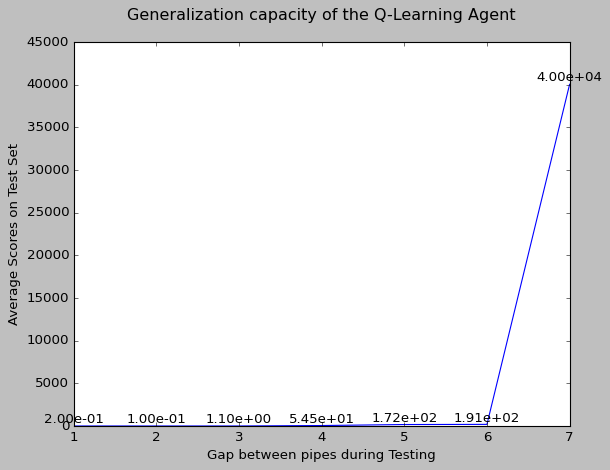

In [47]:
# Plot the parameter sweep graph
plt.plot(pipe_gap_list, avg_scores)
plt.xlabel("Gap between pipes during Testing")
plt.ylabel("Average Scores on Test Set")
plt.title("Generalization capacity of the Q-Learning Agent", pad=20)

# Add value for each point
for x, y in zip(pipe_gap_list, avg_scores):
    plt.text(x, y, f"{y:.2e}", ha="center", va="bottom")


plt.show()

## Agent n°2: Monte Carlo

### Class definition

In [49]:
class MonteCarlo:
    def __init__(self, gamma, epsilon=0.1):
        """
        Initialize the Monte Carlo agent.

        Args:
            env (gym.Env): The environment to use.
            gamma (float): The discount factor.
            n_episodes (int): The number of episodes to train for.
            epsilon (float): The probability of selecting a random action.
        """
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: 0)
        self.N = defaultdict(lambda: 0)
    
    def choose_action(self, state):
        """
        Choose an action to take given a state.

        Args:
            state: The current state.

        Returns:
            The chosen action.
        """
        
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(2)
        else:
            return np.argmax([self.Q[(state,0)],self.Q[(state,1)]])

    def update_Q(self, episode):
        """
        Update the Q values given an episode.

        Args:
            episode: The episode to use for updating.

        Returns:
            None.
        """
        
        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            if (state, action) not in visited:
                self.N[(state, action)] += 1
                self.Q[(state, action)] += (G - self.Q[state, action]) / self.N[state, action]
                visited.add((state, action))
    
    def train(self,env, n_episodes):
        """Train the agent (include both exploration and exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to train the agent on
            
        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list) : list of the scores obtained for each episode
        """
        rewards = []
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            episode = []
            episode_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward,done,_, info = env.step(action)
                episode.append((state, action, reward))
                episode_reward += reward
                state = next_state
            self.update_Q(episode)
            rewards.append(episode_reward)
            scores.append(info['score'])
        return rewards,scores  
    
    def test(self,env, n_episodes):
        """Test the agent (include only exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to train the agent on
            
        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list): list of the scores obtained for each episode
        """
        rewards = []
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            episode_reward = 0
            while not done:
                action = np.argmax([self.Q[state,0],self.Q[state,1]])
                next_state, reward,done,_, info = env.step(action)
                episode_reward += reward
                state = next_state
                if info['score'] >1e5: #Stopping condition to avoid it to be stuck if it never dies
                    break
            rewards.append(episode_reward)
            scores.append(info['score'])
        return rewards,scores


### Baseline

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2956.83it/s]


Average reward over 10000 train episodes: 21.2053
Median reward over 10000 train episodes: 13.0
Average scores over 10000 train episodes: 0.8939
Median scores over 10000 train episodes: 0.0


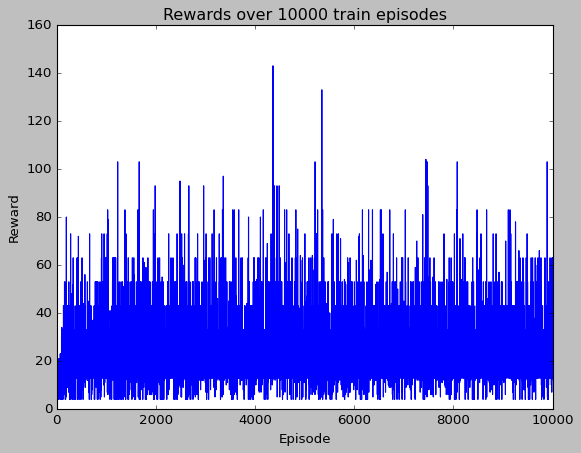

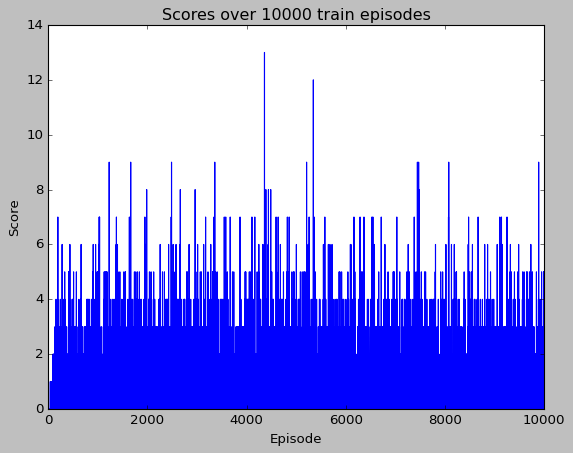

In [50]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)


n_episodes = 10000
# create the Monte Carlo agent
mc_agent = MonteCarlo(gamma=0.5, epsilon=0.5)

# train the Monte Carlo agent
train_rewards, train_scores = mc_agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Average scores over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median scores over {n_episodes} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()


### Hyperparameter 

#### Epsilon

In [51]:
labels = ["epsilon = 0.1", "epsilon = 0.2","epsilon = 0.3", "epsilon = 0.4","epsilon = 0.5", "epsilon = 0.6", "epsilon = 0.7"]
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.7]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for eps in epsilon:
    n_episodes = 10000
    # create the Monte Carlo agent
    mc_agent = MonteCarlo(gamma=0.5, epsilon=eps)

    # train the Monte Carlo agent
    train_rewards, train_scores = mc_agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3969.84it/s]


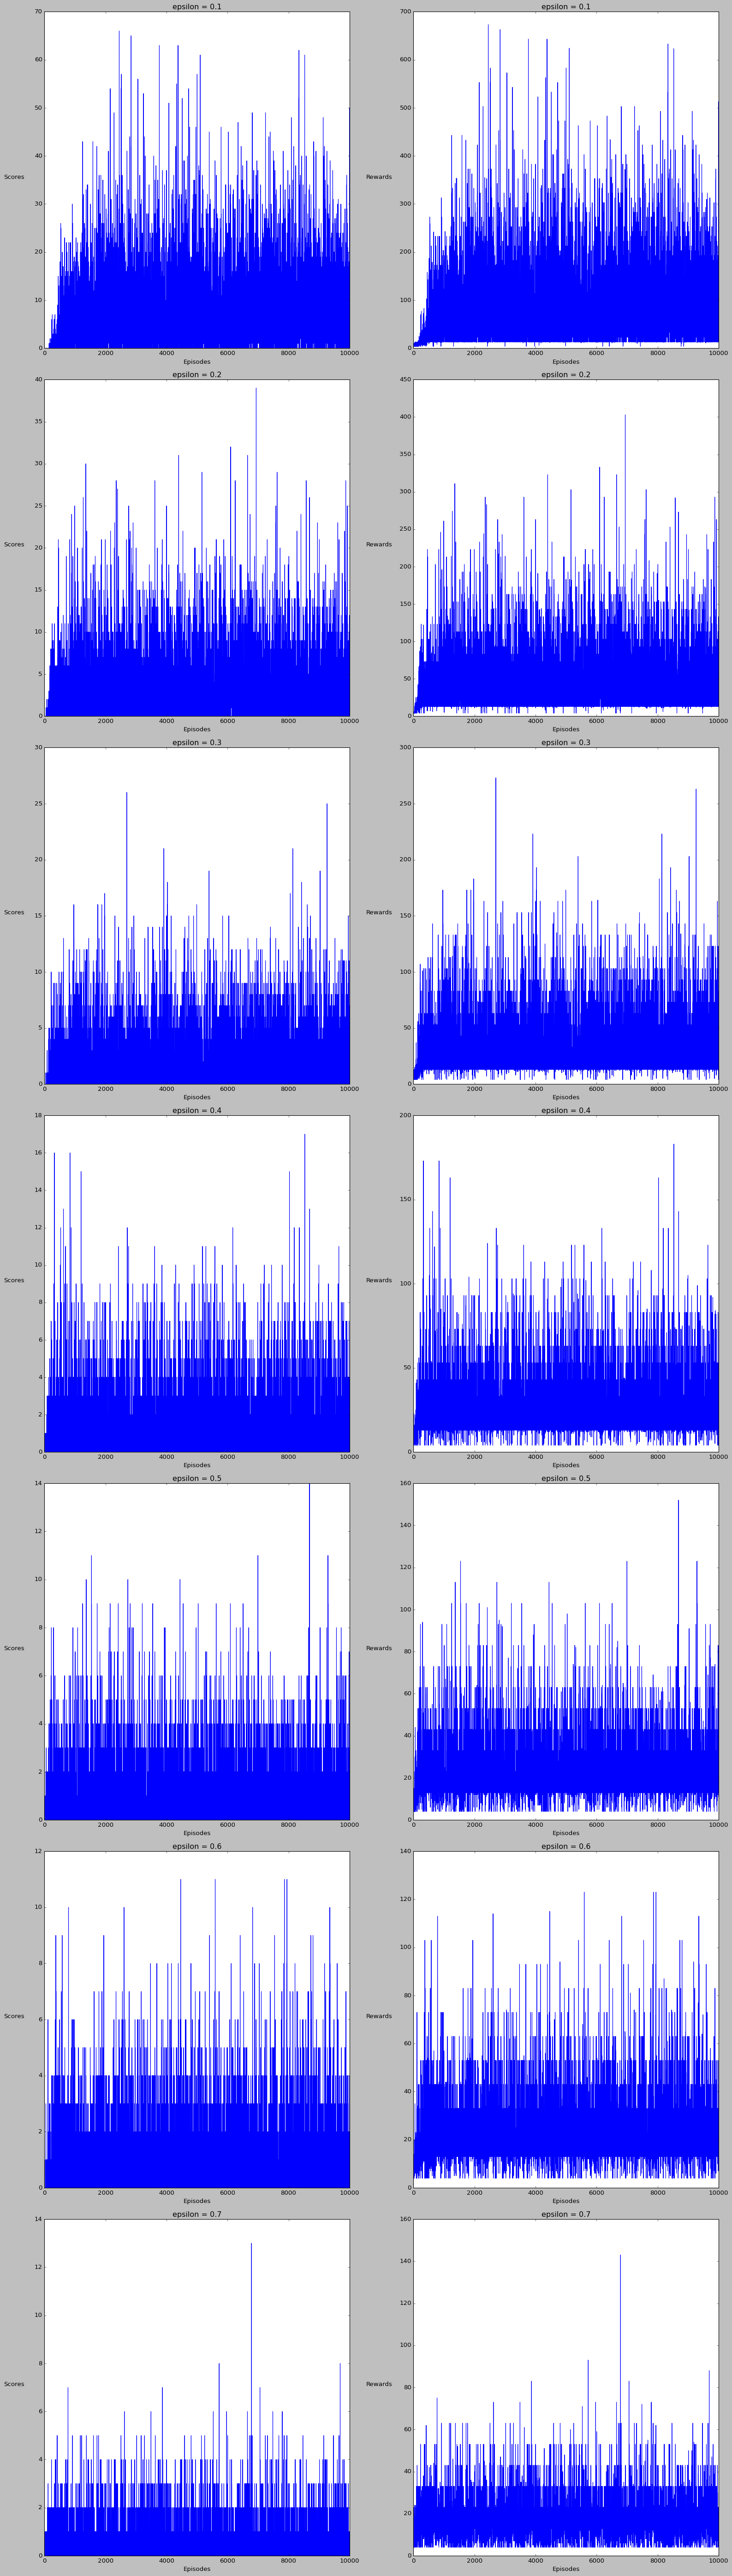

In [52]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("Episodes")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [53]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒═══════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label         │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞═══════════════╪═════════════════╪═══════════════════╪════════════════╡
│ epsilon = 0.1 │         82.0465 │                53 │            673 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.2 │         44.8303 │                33 │            403 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.3 │         32.9388 │                23 │            273 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.4 │         25.5607 │                23 │            183 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.5 │         21.901  │                13 │            152 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.6 │         21.4668 │                

#### Gamma

In [75]:
labels = ["Gamma = 0.5", "Gamma = 0.6", "Gamma = 0.7","Gamma = 0.8","Gamma = 0.9","Gamma = 0.9999"]
gamma = [0.5, 0.6, 0.7,0.8,0.9,0.9999]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for gam in gamma:
    n_episodes = 10000
    # create the Monte Carlo agent
    mc_agent = MonteCarlo(gamma=gam, epsilon=0.1)

    # train the Monte Carlo agent
    train_rewards, train_scores = mc_agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 994.43it/s]


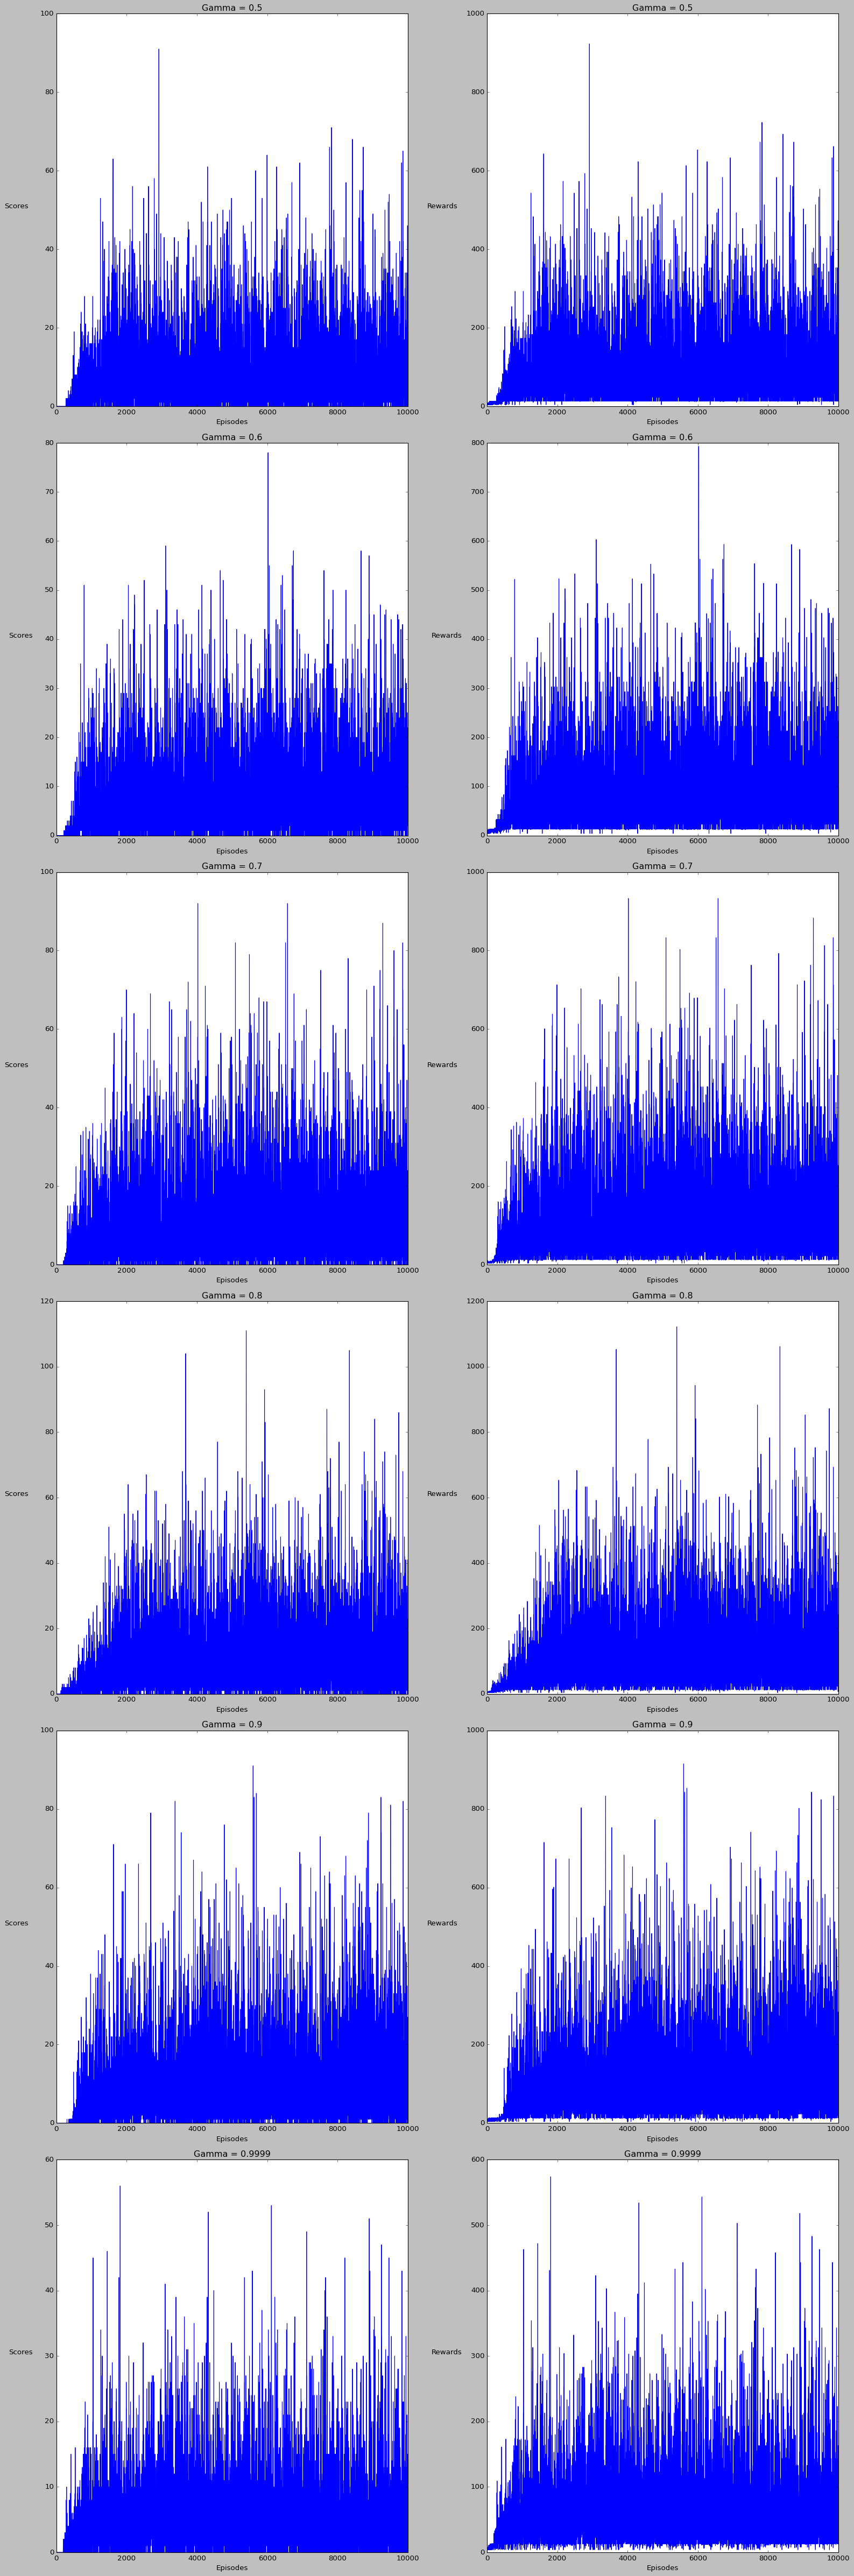

In [76]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("Episodes")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [77]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒════════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label          │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞════════════════╪═════════════════╪═══════════════════╪════════════════╡
│ Gamma = 0.5    │         88.8238 │                63 │            923 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.6    │         83.872  │                55 │            793 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.7    │        109.425  │                73 │            933 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.8    │        109.054  │                73 │           1122 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.9    │        103.559  │                72 │            915 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.9999 │         62.6936 │  

### Optimal Model

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:37<00:00, 529.32it/s]


Average reward over 20000 train episodes: 117.1484
Median reward over 20000 train episodes: 83.0
Average scores over 20000 train episodes: 10.50455
Median scores over 20000 train episodes: 7.0


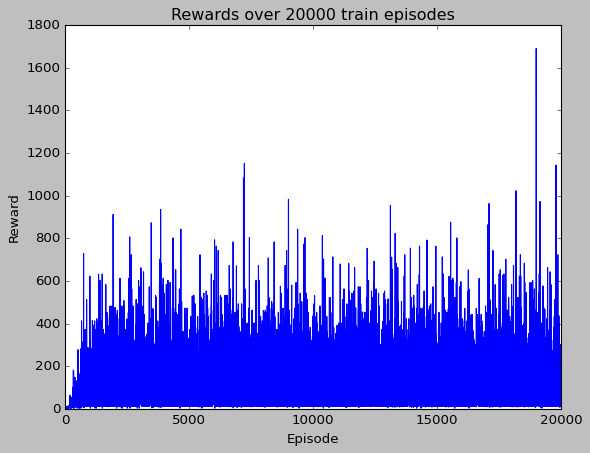

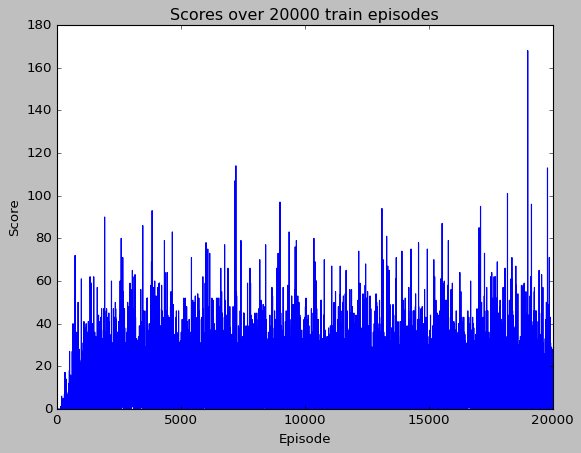

In [72]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)


n_episodes = 20000
# create the Monte Carlo agent
mc_agent = MonteCarlo(gamma=0.9, epsilon=0.1)

# train the Monte Carlo agent
train_rewards, train_scores = mc_agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Average scores over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median scores over {n_episodes} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:46<00:00, 10.63s/it]

Average reward over 10 test episodes: 1000014.0
Median reward over 10 test episodes: 1000014.0
Average scores over 10 test episodes: 100001.0
Median scores over 10 test episodes: 100001.0


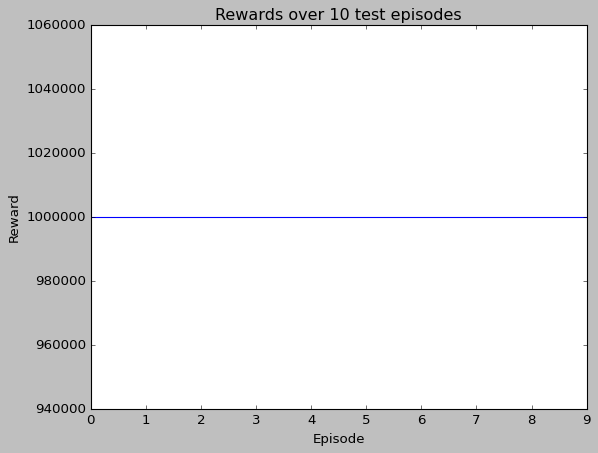

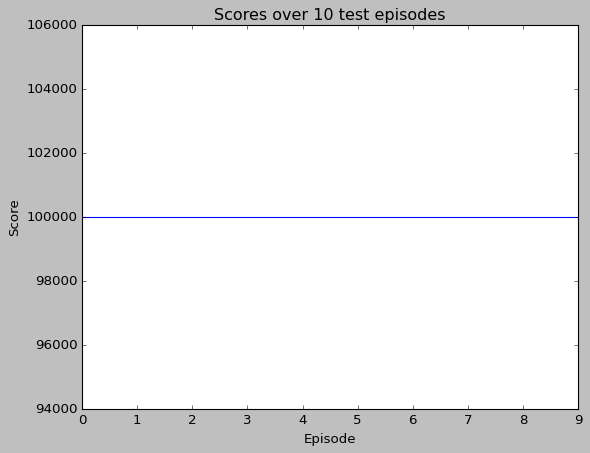

In [60]:
# test the trained agent for 10 episodes
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
n_episodes=10
test_rewards,test_scores = mc_agent.test(env,n_episodes)
print(f"Average reward over {n_episodes} test episodes:", np.mean(test_rewards))
print(f"Median reward over {n_episodes} test episodes:", np.median(test_rewards))
print(f"Average scores over {n_episodes} test episodes:", np.mean(test_scores))
print(f"Median scores over {n_episodes} test episodes:", np.median(test_scores))


# plot the rewards
plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} test episodes")
plt.show()

# plot the scores
plt.plot(test_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} test episodes")
plt.show()

### Performance Graphs

#### Convergence time

In [61]:
# Set up a list of episodes to test
num_episodes_list = [1000, 2000, 3000, 4000, 5000]

# Set up a list to store the average scores/rewards
avg_scores = []
avg_rewards= []

# Loop through each episode count
for num_episodes in num_episodes_list:
    
    # Initialize the environment
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

    # Train the Monte Carlo agent on the specified number of episodes
    mc_agent = MonteCarlo(gamma=0.9, epsilon=0.1)
    mc_agent.train(env,num_episodes)

    # Test the agent on the test set
    test_rewards,test_scores = mc_agent.test(env,10)

    # Calculate the average score for the test set
    avg_score = np.mean(test_scores)
    avg_reward = np.mean(test_rewards)
    
    # Add the average score/reward to the list
    avg_scores.append(avg_score)
    avg_rewards.append(avg_reward)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:46<00:00, 10.67s/it]


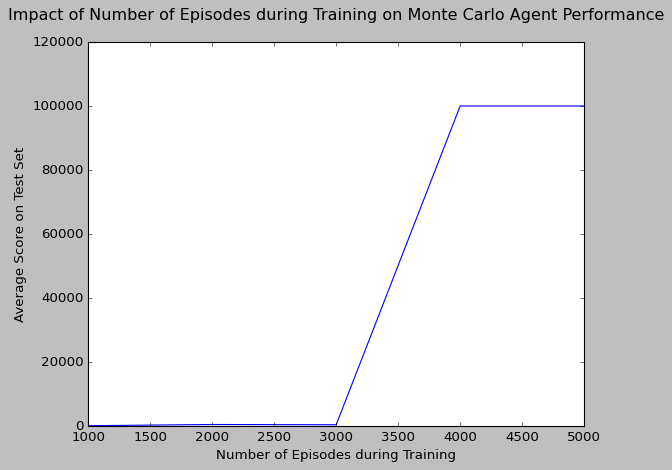

In [62]:
# Plot the parameter sweep graph
plt.plot(num_episodes_list, avg_scores)
# plt.plot(num_episodes_list, avg_rewards)
plt.xlabel("Number of Episodes during Training")
plt.ylabel("Average Score on Test Set")
plt.title("Impact of Number of Episodes during Training on Monte Carlo Agent Performance", pad=20)
plt.show()


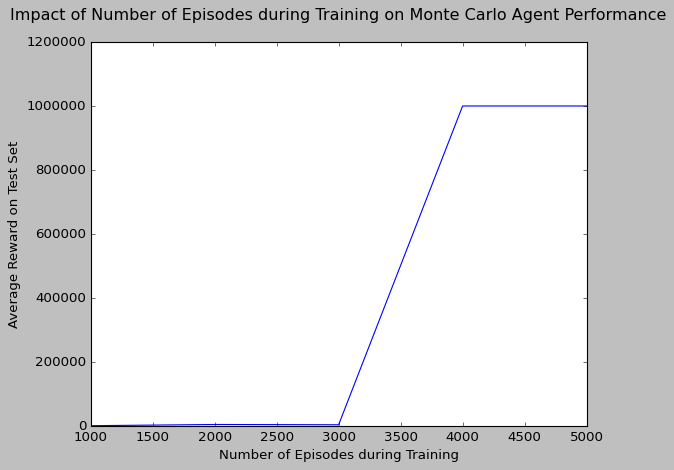

In [63]:
# Plot the parameter sweep graph
plt.plot(num_episodes_list, avg_rewards)
plt.xlabel("Number of Episodes during Training")
plt.ylabel("Average Reward on Test Set")
plt.title("Impact of Number of Episodes during Training on Monte Carlo Agent Performance", pad=20)
plt.show()


#### Generalization

In [64]:
# Set up a list of pipe gap to test
pipe_gap_list = [1, 2, 3,4,5,6,7]

# Set up a list to store the average scores/rewards
avg_scores = []
avg_rewards= []

# Train the MC agent on a training environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
mc_agent = MonteCarlo(gamma=0.9, epsilon=0.1)
mc_agent.train(env,4000)

# Loop through each pipe gap
for pipe_gap in pipe_gap_list:
    
    # Initialize the environment with the pipe gap
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=pipe_gap)

    # Test the agent on the test set
    test_rewards,test_scores = mc_agent.test(env,10)

    # Calculate the average score for the test set
    avg_score = np.mean(test_scores)
    avg_reward = np.mean(test_rewards)
    
    # Add the average score/reward to the list
    avg_scores.append(avg_score)
    avg_rewards.append(avg_reward)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:45<00:00, 10.53s/it]


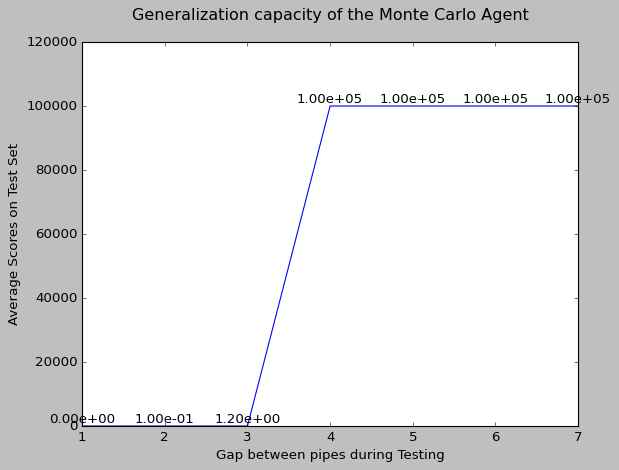

In [65]:
# Plot the parameter sweep graph
plt.plot(pipe_gap_list, avg_scores)
plt.xlabel("Gap between pipes during Testing")
plt.ylabel("Average Scores on Test Set")
plt.title("Generalization capacity of the Monte Carlo Agent", pad=20)

# Add value for each point
for x, y in zip(pipe_gap_list, avg_scores):
    plt.text(x, y, f"{y:.2e}", ha="center", va="bottom")


plt.show()

## State-Value Functions

### Agent n°1: Q-Learning

In [66]:
def get_statevalue(x, y, Q):
    """
    Calculates the state-value function for a given state (x,y) using the Q-table.
    
    Args:
        x (int): x-coordinate of the state
        y (int): y-coordinate of the state
        Q (dict): Q-table containing state-action values
        
    Returns:
        float: state-value function for the given state (x,y)
    """
    state = (x, y)
    returns = []
    actions = [0, 1]  # Possible actions in the game
    
    # Loop over all possible actions and calculate their returns
    for action in actions:
        next_state = ((x+1, y+1),action)  # The next state after taking the given action
        if next_state in list(Q.keys()):
            returns.append(Q[next_state])
        else:
            returns.append(0.0)
    
    # Calculate the state-value as the average of the returns
    if len(returns) > 0:
        state_value = np.mean(returns)
    else:
        state_value = 0.0
    
    return state_value

In [67]:
def get_optimal_action(x, y, Q):
    """
    Calculates the optimal action for a given state (x,y) using the Q-table.
    
    Args:
        x (int): x-coordinate of the state
        y (int): y-coordinate of the state
        Q (dict): Q-table containing state-action values
        
    Returns:
        int: the optimal action (0 or 1) for the given state (x,y)
    """
    state = (x, y)
    actions = [0, 1]  # Possible actions in the game
    action_values = []
    
    # Calculate the action-values for each possible action
    for action in actions:
        next_state = ((x+1, y+1),action)  # The next state after taking the given action
        if next_state in list(Q.keys()):
            action_values.append(Q[next_state])
        else:
            action_values.append(0.0)
    
    # Return the optimal action based on the action-values
    if action_values[0]==0 and action_values[1]==0:
        return -1
    elif action_values[0] > action_values[1]:
        return 0
    else:
        return 1

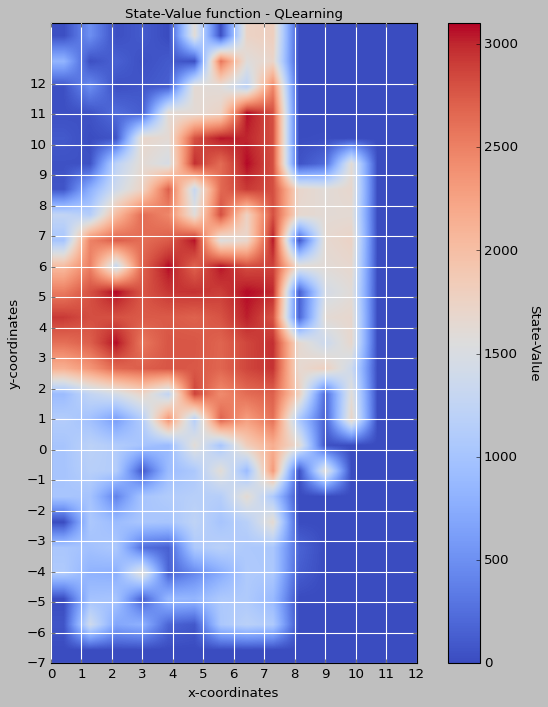

In [79]:
# Get the range of x/y-axis for the plot
x_values_MC = []
y_values_MC = []
for state in agent.q.keys():
    x = state[0][0]
    y = state[0][1]
    if x not in x_values_MC:
        x_values_MC.append(x)
    if y not in y_values_MC:
        y_values_MC.append(y)
# Prepare the plot
x_range = sorted(x_values_MC)
y_range = sorted(y_values_MC)

X, Y = np.meshgrid(x_range, y_range)
Z = np.array([[get_statevalue(x, y, agent.q) for x in x_range] for y in y_range])

# Generate the plot
plt.figure(figsize=(10, 10))
plt.xticks(x_range)
plt.yticks(y_range)
surf = plt.imshow(Z, cmap=plt.get_cmap('coolwarm'), extent=[0, 12, -7, 14])
plt.title('State-Value function - QLearning', fontsize='medium')
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.grid(color='w', linestyle='-', linewidth=1)
cbar = plt.colorbar(surf)
cbar.ax.set_ylabel('State-Value', rotation=270, labelpad=20)
plt.show()


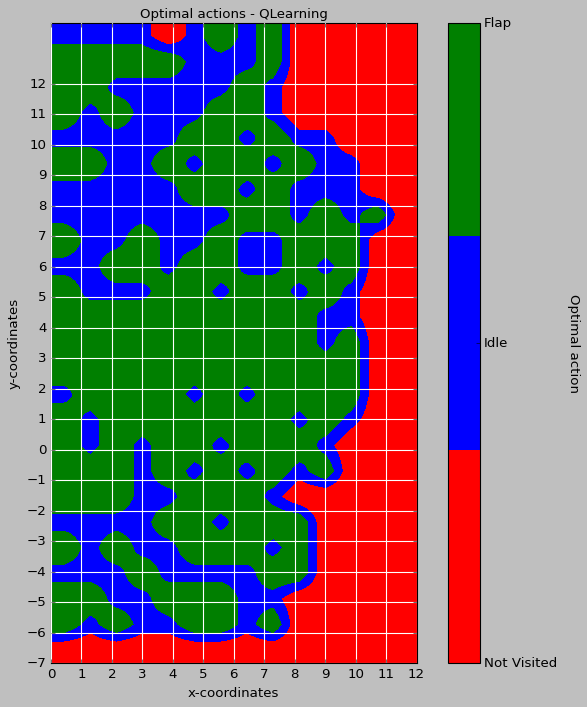

In [80]:
# Get the range of x/y-axis for the plot
x_values_MC = []
y_values_MC = []
for state in agent.q.keys():
    x = state[0][0]
    y = state[0][1]
    if x not in x_values_MC:
        x_values_MC.append(x)
    if y not in y_values_MC:
        y_values_MC.append(y)
        
# Prepare the plot
x_range = sorted(x_values_MC)
y_range = sorted(y_values_MC)

# Calculate the optimal action for each state on the grid
optimal_actions = np.array([[get_optimal_action(x, y, agent.q) for x in x_range] for y in y_range])

# Generate the plot
plt.figure(figsize=(10, 10))
plt.xticks(x_range)
plt.yticks(y_range)
cmap = ListedColormap(['r','b', 'g'])  # Red for idle, green for flap
plt.imshow(optimal_actions, cmap=cmap, extent=[0, 12, -7, 14])
plt.title('Optimal actions - QLearning', fontsize='medium')
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.grid(color='w', linestyle='-', linewidth=1)
cbar = plt.colorbar(ticks=[-1,0, 1])
cbar.ax.set_yticklabels(['Not Visited','Idle', 'Flap'])
cbar.ax.set_ylabel('Optimal action', rotation=270, labelpad=20)
plt.show()


### Agent n°2: Monte Carlo

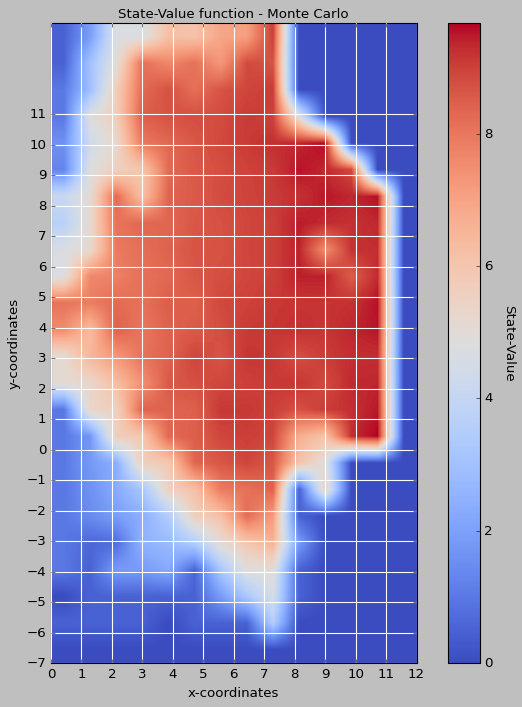

In [73]:
# Get the range of x/y-axis for the plot
x_values_MC = []
y_values_MC = []
for state in mc_agent.Q.keys():
    x = state[0][0]
    y = state[0][1]
    if x not in x_values_MC:
        x_values_MC.append(x)
    if y not in y_values_MC:
        y_values_MC.append(y)
# Prepare the plot
x_range = sorted(x_values_MC)
y_range = sorted(y_values_MC)

X, Y = np.meshgrid(x_range, y_range)
Z = np.array([[get_statevalue(x, y, mc_agent.Q) for x in x_range] for y in y_range])

# Generate the plot
plt.figure(figsize=(10, 10))
plt.xticks(x_range)
plt.yticks(y_range)
surf = plt.imshow(Z, cmap=plt.get_cmap('coolwarm'), extent=[0, 12, -7, 14])
plt.title('State-Value function - Monte Carlo', fontsize='medium')
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.grid(color='w', linestyle='-', linewidth=1)
cbar = plt.colorbar(surf)
cbar.ax.set_ylabel('State-Value', rotation=270, labelpad=20)
plt.show()


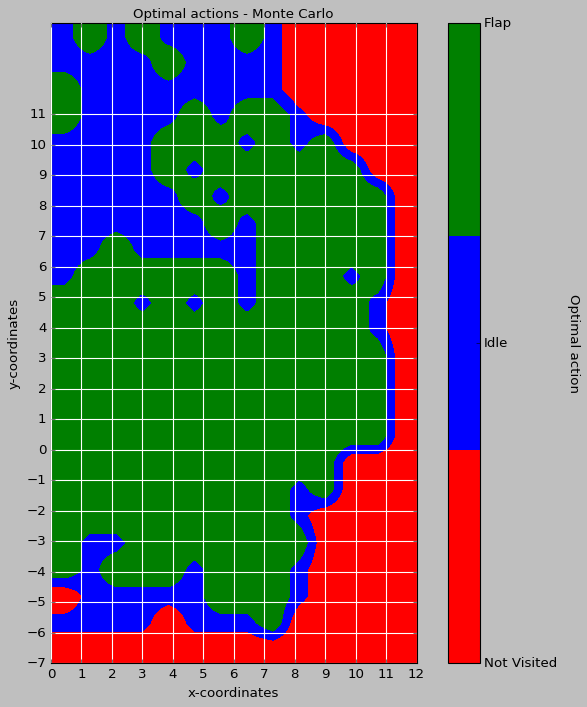

In [74]:
# Get the range of x/y-axis for the plot
x_values_MC = []
y_values_MC = []
for state in mc_agent.Q.keys():
    x = state[0][0]
    y = state[0][1]
    if x not in x_values_MC:
        x_values_MC.append(x)
    if y not in y_values_MC:
        y_values_MC.append(y)
        
# Prepare the plot
x_range = sorted(x_values_MC)
y_range = sorted(y_values_MC)

# Calculate the optimal action for each state on the grid
optimal_actions = np.array([[get_optimal_action(x, y, mc_agent.Q) for x in x_range] for y in y_range])

# Generate the plot
plt.figure(figsize=(10, 10))
plt.xticks(x_range)
plt.yticks(y_range)
cmap = ListedColormap(['r','b', 'g'])  # Red for idle, green for flap
plt.imshow(optimal_actions, cmap=cmap, extent=[0, 12, -7, 14])
plt.title('Optimal actions - Monte Carlo', fontsize='medium')
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.grid(color='w', linestyle='-', linewidth=1)
cbar = plt.colorbar(ticks=[-1,0, 1])
cbar.ax.set_yticklabels(['Not Visited','Idle', 'Flap'])
cbar.ax.set_ylabel('Optimal action', rotation=270, labelpad=20)
plt.show()
